### Prelab 11

In [146]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
warnings.filterwarnings('ignore')
import numpy as np

##### Select desired gain-crossover frequency

In [169]:
w_cutoff = (50e3 / 8) * 2 * sp.pi
w_gc = w_cutoff / 1.5
PM = 60 / 180 * 2 * sp.pi
print(f"Our desired crossover frequency is {w_gc} rad/s, with a phase margin of {PM} rad.")

Our desired crossover frequency is 8333.33333333333*pi rad/s, with a phase margin of 0.666666666666667*pi rad.


##### Measure or calculate actual gain and phase margin at desired gain-crossover frequency

Our actual gain is 12.187 dB with a phase margin of -103.903 degrees at our desired crossover frequency 4166.7 Hz.


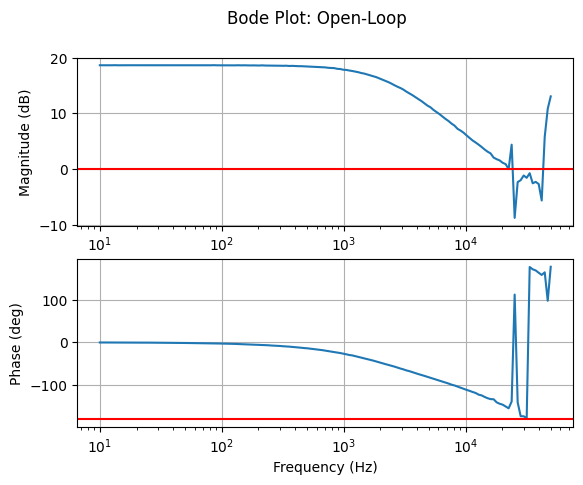

In [171]:
fig, ax = plt.subplots(2, 1)  
data_ol = pd.read_csv(f"../../lab9/ad2/10v.csv", skiprows=20)    
plt.subplot(2, 1, 1)
plt.grid(visible=True)
plt.semilogx(data_ol['Frequency (Hz)'], data_ol['Channel 2 Magnitude (dB)'])
plt.axline((data_ol['Frequency (Hz)'][0],0),(data_ol['Frequency (Hz)'][len(data_ol)-1],0),c='red')
plt.ylabel('Magnitude (dB)')

plt.subplot(2, 1, 2)
plt.grid(visible=True)
plt.semilogx(data_ol['Frequency (Hz)'], data_ol['Channel 2 Phase (deg)'])
plt.axline((data_ol['Frequency (Hz)'][0],-180),(data_ol['Frequency (Hz)'][len(data_ol)-1],-180),c='red')
plt.ylabel("Phase (deg)")
plt.xlabel("Frequency (Hz)")

# cutoff_frequency = data_ol['Frequency (Hz)'][cutoff_idx]
# print(f"Cutoff frequency for V is {cutoff_idx['Frequency (Hz)']:.1f} Hz with a starting magnitude of {cutoff_value + 3:.2f} dB.")
fig.suptitle("Bode Plot: Open-Loop")

desired_freq_idx = (data_ol[data_ol['Frequency (Hz)'] > (w_gc / 2 / sp.pi)]).iloc[0]
print(f"Our actual gain is {desired_freq_idx['Channel 2 Magnitude (dB)']:.3f} dB with a phase margin of {- 180 - desired_freq_idx['Channel 2 Phase (deg)']:.3f} degrees at our desired crossover frequency {w_gc / 2 / sp.pi:.1f} Hz.")

##### Set $K_p$ 

In [179]:
Kp = -desired_freq_idx['Channel 2 Magnitude (dB)']
print(f"Our Kp value is {Kp:.3f} dB.")
Kp = 10**(Kp/20)

Our Kp value is -12.187 dB.


##### K and phase boost required

In [184]:
phase_boost = PM - (180 + (desired_freq_idx['Channel 2 Phase (deg)']) - 90) * 2 * sp.pi / 180
K = sp.tan((PM-phase_boost)/2 + sp.pi/4)
print(f"Our phase boost is {phase_boost} with a K-value of {sp.N(K):.3f}.")

Our phase boost is 0.512191535663839*pi with a K-value of 1.658.


##### Available Components

In [166]:
R_bases = np.array([1, 1.2, 1.5, 1.8, 2, 2.2, 2.7, 3.3, 3.9, 4.3, 4.7, 5.1, 5.6, 6.8, 7.5, 8.2])
resistors = np.concatenate((R_bases, 10*R_bases, 1e2*R_bases, 1e3*R_bases, 1e4*R_bases, 1e5*R_bases, [1e6]))
caps = [2e-12, 1e-9, 0.1e-6, 3e-12, 1.5e-9, 0.15e-6, 5e-12, 2.2e-9, 0.22e-6, 10e-12,
        3.3e-9, 0.33e-6, 15e-12, 4.7e-9, 0.47e-6, 22e-12, 6.8e-9, 0.68e-6, 30e-12,
        10e-9, 1e-6, 33e-12, 15e-9, 2.2e-6, 47e-12, 22e-9, 4.7e-6, 68e-12, 47e-9,
        10e-6, 75e-12, 68e-9, 82e-12, 100e-12, 150e-12, 220e-12, 330e-12, 470e-12, 680e-12]


##### Parts calculated

In [152]:
def find_closest_match(value, components):
    diffs = np.abs(np.subtract(components, value))
    return  components[np.argmin(diffs)]

In [189]:
Rf1 = 4.3e3
DC_gain = sp.N(Kp*w_gc*sp.sqrt((1+K**(-2))/(1+K**2)))
Vdd = 10

Cc1 = find_closest_match(1/(Rf1*DC_gain), caps)
actual_dc_gain = 1/(Rf1*Cc1)
print("Actual DC Gain:", actual_dc_gain, "; Desired DC Gain:", DC_gain)
Cc2 = find_closest_match(Cc1/K**2, caps)
actual_K = sp.sqrt(Cc1/Cc2)
print("Actual K:", actual_K, "; Desired K:", sp.N(K))
Rc1 = find_closest_match(1/(w_gc * sp.sqrt(Cc1*Cc2)), resistors)
actual_wc = 1/(Rc1*sp.sqrt(Cc1*Cc2))
print("Actual w_c:", actual_wc / 2 / np.pi, "Hz; Desired w_c:", sp.N(w_gc / 2 / np.pi), "Hz")
Rf2 = find_closest_match(Rf1*(2.5/(Vdd-2.5)), resistors)
actual_vdd = (Rf1/Rf2 * 2.5) + 2.5
print("Actual vdd:", actual_vdd, "; Desired vdd:", Vdd)

print("R2:", Rf1, 
      "\n C1:", Cc1,
      "\n C2:", Cc2,
      "\n R5:", Rc1,
      "\n R3:", Rf2)


Actual DC Gain: 3419.972640218878 ; Desired DC Gain: 3881.97964781804
Actual K: 1.75809814598307 ; Desired K: 1.65789962258247
Actual w_c: 4114.85309373385 Hz; Desired w_c: 4166.66666666667 Hz
Actual vdd: 9.666666666666668 ; Desired vdd: 10
R2: 4300.0 
 C1: 6.8e-08 
 C2: 2.2e-08 
 R5: 1000.0 
 R3: 1500.0
